In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import psycopg2
from scipy import stats
from pylab import rcParams

##     Alternate_Hypothesis : Mean_next_roas is greater than Mean_Same_roas
##     Null_Hypothesis : Mean_same_roas is = or less than Mean_next_roas

In [151]:
%matplotlib inline
np.random.seed(8)
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 20,10
rcParams['font.size'] = 30
sns.set()

In [152]:
conn = psycopg2.connect(user = "ds_readonly", password = "blkbox2020!",host = "db.blkbox.ai",port = "5432",database = "blkbox")
sql = """SELECT adaccount_id, adaccount_name, optimization_metric, goal, date, 
  (SUM(spend) / NULLIF(SUM(installs), 0)) as cpi,
  (SUM(spend) / NULLIF(SUM(unique_purchases), 0)) as cpa,
  (SUM(d7_purchase_value) / NULLIF(SUM(spend), 0)) as d7_roas,
  SUM(spend) as spend
FROM (
  SELECT fb_adaccount.adaccount_id, fb_adaccount.adaccount_name,
    fb_adaccount.optimization_metric, fb_campaigns.targeting as region,
    fb_campaigns.optimization as optimization,
    CASE 
      WHEN (COALESCE(fb_campaigns.optimization_metric, fb_adaccount.optimization_metric) = 'd7_roas') AND ((fb_adaccount.targets->>'d7_roas')::numeric) < ((entity_performance.d7_roas)::numeric) THEN 'above'
      WHEN (COALESCE(fb_campaigns.optimization_metric, fb_adaccount.optimization_metric) = 'cpi') AND ((fb_adaccount.targets->>'cpi')::numeric)>((entity_performance.cpi)::numeric) THEN 'above'
      WHEN (COALESCE(fb_campaigns.optimization_metric, fb_adaccount.optimization_metric) = 'cpa') AND ((fb_adaccount.targets->>'cpa')::numeric)>((entity_performance.cpa)::numeric) THEN 'above'
    ELSE 'below' END AS goal,
    cpa, cpi, d7_roas, d7_purchase_value, spend, installs, unique_purchases, entity_performance.date
  FROM fb_app_ads fb_ads
  INNER JOIN  fb_app_adaccounts fb_adaccount
  ON fb_ads.adaccount_id=fb_adaccount.adaccount_id
  INNER JOIN fb_app_campaigns as fb_campaigns
  ON fb_ads.campaign_id = fb_campaigns.campaign_id
  INNER JOIN (
    SELECT adaccount_id, entity_id, date, CAST(metadata->>'cpa' as float) AS cpa,
      CAST(metadata->>'cpi' as float) AS cpi,
      CAST(metadata->>'d7_roas' AS float) AS d7_roas,
      CAST(metadata->>'d7_purchase_value' AS float) AS d7_purchase_value,
      CAST(metadata->>'spend' AS float) AS spend,
      CAST(metadata->>'installs' AS float) AS installs,
      CAST(metadata->>'unique_purchases' AS float) AS unique_purchases
    FROM blkbox_performance_history WHERE date >= '2021-07-01'
  ) as entity_performance
  ON entity_performance.adaccount_id = fb_ads.adaccount_id
  AND entity_performance.entity_id = fb_ads.ad_id 
) as info WHERE info.adaccount_id = 'act_1007332209799361'
GROUP BY 1,2,3,4,5 ORDER BY date;"""
data = pd.read_sql_query(sql, conn)
conn = None


In [153]:
print(data.head())
print()
print(data.shape)

           adaccount_id  adaccount_name optimization_metric   goal  \
0  act_1007332209799361  Medal: ANDROID           retention  below   
1  act_1007332209799361  Medal: ANDROID           retention  below   
2  act_1007332209799361  Medal: ANDROID           retention  below   
3  act_1007332209799361  Medal: ANDROID           retention  below   
4  act_1007332209799361  Medal: ANDROID           retention  below   

         date       cpi   cpa  d7_roas   spend  
0  2021-07-01  1.334732  None      0.0  1272.0  
1  2021-07-02  1.179676  None      0.0   801.0  
2  2021-07-03  1.202454  None      0.0   784.0  
3  2021-07-04  1.191729  None      0.0   951.0  
4  2021-07-05  1.157303  None      0.0   721.0  

(66, 9)


In [162]:
data.to_csv("data.csv",index= False)

In [3]:
data = pd.read_csv("data.csv")

In [4]:
data.head()

,adaccount_id,adaccount_name,optimization_metric,goal,date,cpi,cpa,d7_roas,spend
0,act_1007332209799361,Medal: ANDROID,retention,below,2021-07-01,1.334732,NaN,0.0,1272.0
1,act_1007332209799361,Medal: ANDROID,retention,below,2021-07-02,1.179676,NaN,0.0,801.0
2,act_1007332209799361,Medal: ANDROID,retention,below,2021-07-03,1.202454,NaN,0.0,784.0
3,act_1007332209799361,Medal: ANDROID,retention,below,2021-07-04,1.191729,NaN,0.0,951.0
4,act_1007332209799361,Medal: ANDROID,retention,below,2021-07-05,1.157303,NaN,0.0,721.0


In [5]:
data_below = data[(data['goal'] == 'above')]
data_above = data[(data['goal'] == 'above')]
data_above['date'] = pd.to_datetime(data_above['date']).apply(pd.DateOffset(-1))
data_above['date'] = data_above['date'].astype(str)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4138: FutureWarning: DateOffset.__call__ is deprecated and will be removed in a future version.  Use `offset + other` instead.
  mapped = lib.map_infer(values, f, convert=convert_dtype)
<ipython-input-5-2878410c16df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_above['date'] = pd.to_datetime(data_above['date']).apply(pd.DateOffset(-1))
<ipython-input-5-2878410c16df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_above['date'] =

In [6]:
data_below.head()

,adaccount_id,adaccount_name,optimization_metric,goal,date,cpi,cpa,d7_roas,spend
9,act_1007332209799361,Medal: ANDROID,retention,above,2021-07-10,0.800479,NaN,0.0,1003.0
11,act_1007332209799361,Medal: ANDROID,retention,above,2021-07-11,0.448402,NaN,0.0,1221.0
13,act_1007332209799361,Medal: ANDROID,retention,above,2021-07-12,0.538399,NaN,0.0,1325.0
15,act_1007332209799361,Medal: ANDROID,retention,above,2021-07-13,0.527037,NaN,0.0,731.0
17,act_1007332209799361,Medal: ANDROID,retention,above,2021-07-14,0.503597,NaN,0.0,560.0


In [7]:
data_above.head()

,adaccount_id,adaccount_name,optimization_metric,goal,date,cpi,cpa,d7_roas,spend
9,act_1007332209799361,Medal: ANDROID,retention,above,2021-07-09,0.800479,NaN,0.0,1003.0
11,act_1007332209799361,Medal: ANDROID,retention,above,2021-07-10,0.448402,NaN,0.0,1221.0
13,act_1007332209799361,Medal: ANDROID,retention,above,2021-07-11,0.538399,NaN,0.0,1325.0
15,act_1007332209799361,Medal: ANDROID,retention,above,2021-07-12,0.527037,NaN,0.0,731.0
17,act_1007332209799361,Medal: ANDROID,retention,above,2021-07-13,0.503597,NaN,0.0,560.0


In [8]:
data_above.dtypes

adaccount_id            object
adaccount_name          object
optimization_metric     object
goal                    object
date                    object
cpi                    float64
cpa                    float64
d7_roas                float64
spend                  float64
dtype: object

In [9]:
res = pd.merge(data_below, data_above, on='date')
res = res[['spend_x','spend_y']]
res['total_spend'] = res['spend_x'] + res['spend_y']
res['spend_x_per'] = res['spend_x'] / res['total_spend'] * 100
res['spend_y_per'] = res['spend_y'] / res['total_spend'] * 100


res.head()

,spend_x,spend_y,total_spend,spend_x_per,spend_y_per
0,1003.0,1221.0,2224.0,45.098921,54.901079
1,1221.0,1325.0,2546.0,47.957581,52.042419
2,1325.0,731.0,2056.0,64.445525,35.554475
3,731.0,560.0,1291.0,56.622773,43.377227
4,560.0,614.0,1174.0,47.700170,52.299830


In [10]:
def plot_distribution(inp):
    plt.figure()
    ax = sns.distplot(inp)
    plt.axvline(np.mean(inp), color = 'k', linestyle='dashed',linewidth=5)
    _, max_ = plt.ylim()
    plt.text(
        inp.mean() + inp.mean() /10,
        max_ - max_ /10,
        "Mean: {:.2f}".format(inp.mean()),
    )
    return plt.figure

In [11]:
res[['spend_x_per','spend_y_per']].describe()

,spend_x_per,spend_y_per
count,25.000000,25.000000
mean,50.922945,49.077055
std,4.161196,4.161196
min,45.098921,35.554475
25%,47.957581,46.991037
50%,50.941029,49.058971
75%,53.008963,52.042419
max,64.445525,54.901079


In [12]:
spend_x = np.array(res['spend_x_per'])
spend_x = [x for x in spend_x if str(x) != 'nan']
spend_y = np.array(res['spend_y_per'])
spend_y = [x for x in spend_y if str(x) != 'nan']


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

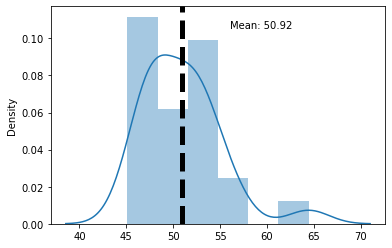

In [13]:
plot_distribution(np.array(spend_x))

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

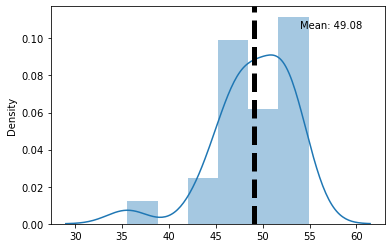

In [14]:
plot_distribution(np.array(spend_y))

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


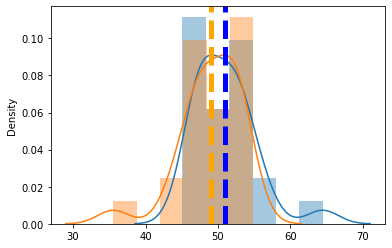

In [15]:
plt.figure()
ax1 = sns.distplot(spend_x)
ax2 = sns.distplot(spend_y)
plt.axvline(np.mean(spend_x),color = 'b', linestyle='dashed',linewidth=5)
plt.axvline(np.mean(spend_y),color = 'orange', linestyle='dashed',linewidth=5)

In [16]:
def compare(arr1,arr2,alpha,sample_size):
    stat,p_value = stats.ttest_ind(arr1, arr2, alternative = 'greater')
    print('Statistic:',stat)
    print('p_value:',p_value)
    if p_value < alpha:
        print("Null Hypothesis Rejected")
        print("Mean_same_spend is = or less than Mean_next_spend")  
    else:
        print("Alternate Accepted")
        print("Percent_Mean spend on performing campaigns is greater by Budget_Rebalance")
        

In [17]:
sample_size = 25
previous_sample = np.random.choice(np.array(spend_x),sample_size)
previous_sample = [int(i) for i in previous_sample]
print(previous_sample)
next_sample = np.random.choice(np.array(spend_y),sample_size)
next_sample = [int(i) for i in next_sample]
print(next_sample)
compare(previous_sample,next_sample,0.02,sample_size) 

[51, 48, 64, 50, 52, 48, 51, 50, 53, 53, 50, 47, 50, 52, 47, 45, 50, 47, 48, 49, 51, 51, 51, 48, 48]
[46, 52, 52, 48, 35, 48, 52, 47, 49, 49, 48, 46, 52, 53, 50, 48, 51, 44, 46, 52, 49, 48, 52, 51, 53]
Statistic: 1.2675131651392468
p_value: 0.1055432754114667
Alternate Accepted
Percent_Mean spend on performing campaigns is greater by Budget_Rebalance


## Below VS Above comparision

In [20]:
data_below = data[(data['goal'] == 'below')]
data_above = data[(data['goal'] == 'above')]

In [21]:
res1 = pd.merge(data_below, data_above, on='date')
res1 = res1[['spend_x','spend_y']]
res1['total_spend'] = res1['spend_x'] + res1['spend_y']
res1['spend_x_per'] = res1['spend_x'] / res1['total_spend'] * 100
res1['spend_y_per'] = res1['spend_y'] / res1['total_spend'] * 100


res1.head()

,spend_x,spend_y,total_spend,spend_x_per,spend_y_per
0,660.0,1003.0,1663.0,39.687312,60.312688
1,184.0,1221.0,1405.0,13.096085,86.903915
2,243.0,1325.0,1568.0,15.497449,84.502551
3,102.0,731.0,833.0,12.244898,87.755102
4,178.0,560.0,738.0,24.119241,75.880759


In [22]:
res1[['spend_x_per','spend_y_per']].describe()

,spend_x_per,spend_y_per
count,26.000000,26.000000
mean,34.924600,65.075400
std,13.991633,13.991633
min,12.244898,39.457831
25%,24.473833,57.175019
50%,34.322352,65.677648
75%,42.824981,75.526167
max,60.542169,87.755102


In [23]:
spend_x = np.array(res1['spend_x_per'])
spend_x = [x for x in spend_x if str(x) != 'nan']
spend_y = np.array(res1['spend_y_per'])
spend_y = [x for x in spend_y if str(x) != 'nan']

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

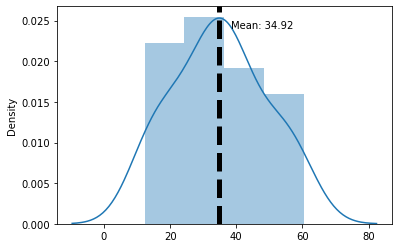

In [24]:
plot_distribution(np.array(spend_x))

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

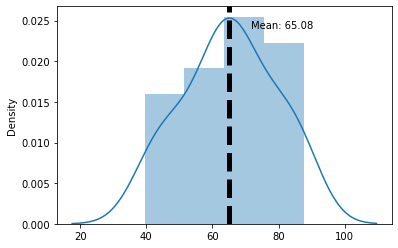

In [25]:
plot_distribution(np.array(spend_y))

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


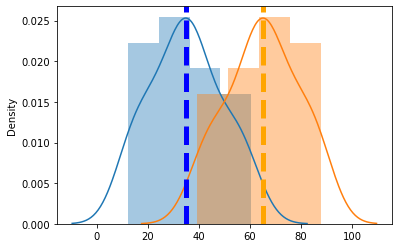

In [26]:
plt.figure()
ax1 = sns.distplot(spend_x)
ax2 = sns.distplot(spend_y)
plt.axvline(np.mean(spend_x),color = 'b', linestyle='dashed',linewidth=5)
plt.axvline(np.mean(spend_y),color = 'orange', linestyle='dashed',linewidth=5)

In [27]:
sample_size = 15
previous_sample = np.random.choice(np.array(spend_x),sample_size)
previous_sample = [int(i) for i in previous_sample]
print(previous_sample)
next_sample = np.random.choice(np.array(spend_y),sample_size)
next_sample = [int(i) for i in next_sample]
print(next_sample)
compare(previous_sample,next_sample,0.05,sample_size)

[13, 33, 13, 34, 13, 19, 24, 28, 39, 24, 24, 55, 43, 43, 24]
[50, 86, 74, 84, 86, 71, 39, 43, 56, 45, 66, 66, 59, 75, 56]
Statistic: -6.805647580911657
p_value: 0.9999998921688243
Alternate Accepted
Percent_Mean spend on performing campaigns is greater by Budget_Rebalance
